# Модель прогнозирования стоимости жилья для агентства недвижимости

Задача — разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок

Провести разведывательный анализ и очистку исходных данных. Обратите
внимание, что данные в таблице реальные: в результате во многих
признаках присутствуют дублирующиеся категории, ошибки ввода,
жаргонные сокращения и т .д. Вам предстоит отыскать закономерности,
самостоятельно расшифровать все сокращения, найти синонимы в
данных, обработать пропуски и удалить выбросы.
Постарайтесь уделить этапу очистки максимум внимания, так как это
напрямую повлияет на результаты моделирования.
2. Выделить наиболее значимые факторы, влияющие на стоимость
недвижимости.
3. Построить модель для прогнозирования стоимости недвижимости.
4. Разработать небольшой веб-сервис, на вход которому поступают данные
о некоторой выставленной на продажу недвижимости, а сервис
прогнозирует его стоимость.

In [40]:
# загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import category_encoders as ce

# 1. Предварительная обработка данных

In [41]:
# загрузка данных в датафрейм
data = pd.read_csv("./data/data.csv")
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (377185, 18)


,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


Описание данных:

➔ 'status' — статус продажи;

➔ 'private pool' и 'PrivatePool' — наличие собственного бассейна;

'propertyType' — тип объекта недвижимости;

➔ 'street' — адрес объекта;

➔ 'baths' — количество ванных комнат;

➔ 'homeFacts' — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);

➔ 'fireplace' — наличие камина;

➔ 'city' — город;

➔ 'schools' — сведения о школах в районе;

➔ 'sqft' — площадь в футах;

➔ 'zipcode' — почтовый индекс;

➔ 'beds' — количество спален;

➔ 'state' — штат;

➔ 'stories' — количество этажей;

➔ 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);

➔ 'target' — цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать).

In [42]:
# определяем наличие дубликатов
data_duplicated = data.duplicated()
data_duplicated.sum()

50

In [43]:
# удаляем дубликаты
data = data.drop_duplicates(ignore_index=True)
data.shape[0]

377135

In [44]:
# смотрим пропуски
data.isna().sum()

status           39917
private pool    372954
propertyType     34733
street               2
baths           106308
homeFacts            0
fireplace       274024
city                34
schools              0
sqft             40550
zipcode              0
beds             91254
state                0
stories         150674
mls-id          352193
PrivatePool     336825
MlsId            66869
target            2480
dtype: int64

Априори прикидываем важность признаков, которым следует уделить максимум внимания:

1. Площадь жилая (sqft)
2. Количество комнат, ванных комнат (beds, baths)
3. Информация о школах (schools)
4. География и расположение (city, street, zipcode)
5. Информация о доме (homefacts, stories)

Поля Mls-Id и MlsId удаляем, так как в них слишком много пропусков и они не несут полезной информации (уникальные идентификаторы)

In [45]:
# удаляем поле
data.drop(labels=['MlsId','mls-id'], axis=1, inplace=True)

### География и расположение

In [46]:
# исследуем географию и расположение объектов, в том числе ищем дубликаты по геополям
adres_data = data[['street', 'city', 'zipcode','state']]
data.loc[adres_data.duplicated()==True].head(5)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target
549,For sale,NaN,Single Family,5398 Alcola Way S,2,"{'atAGlanceFacts': [{'factValue': '1971', 'fac...",Yes,Saint Petersburg,"[{'rating': ['2/10', '4/10', '4/10'], 'data': ...","1,617",33712,3,FL,1.0,Yes,"$280,000"
753,for sale,NaN,lot/land,5428 Closeburn Rd,NaN,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",NaN,Charlotte,"[{'rating': ['8/10', '7/10', '7/10'], 'data': ...","4,595 sqft",28210,5 Beds,NC,3,NaN,"$349,000"
1648,Active,NaN,Single Family Home,8 Potterville Ln,3,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",NaN,Palm Coast,"[{'rating': ['5', '4', '6', '5', 'NR', 'NR', '...",2350,32164,4,FL,One,NaN,"$279,900"
2375,Active,NaN,Single Family Home,16884 W. Vereda Solana Drive,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Surprise,"[{'rating': ['5', '9', '6', '7', '7', 'NR', 'N...","2,856",85387,4,AZ,NaN,NaN,"$373,990"
2643,Active,NaN,Single Family Home,2909 Otis St NE,3.5,"{'atAGlanceFacts': [{'factValue': '1927', 'fac...",NaN,Washington,"[{'rating': ['3', '3', '3', 'NR', '5', '5', 'N...",2848,20018,4,DC,3+,NaN,"$699,000"


In [47]:
# смторим что из себя представляют записи-дубли
data[data['street']=='16884 W. Vereda Solana Drive']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target
236,Active,NaN,Single Family Home,16884 W. Vereda Solana Drive,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Surprise,"[{'rating': ['5', '9', '6', '7', '7', 'NR', 'N...","2,025",85387,4,AZ,NaN,NaN,"$316,990"
2375,Active,NaN,Single Family Home,16884 W. Vereda Solana Drive,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Surprise,"[{'rating': ['5', '9', '6', '7', '7', 'NR', 'N...","2,856",85387,4,AZ,NaN,NaN,"$373,990"
63049,Active,NaN,Single Family Home,16884 W. Vereda Solana Drive,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Surprise,"[{'rating': ['5', '9', '6', '7', '7', 'NR', 'N...","2,207",85387,5,AZ,NaN,NaN,"$331,990"
92132,Active,NaN,Single Family Home,16884 W. Vereda Solana Drive,2.5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Surprise,"[{'rating': ['5', '9', '6', '7', '7', 'NR', 'N...","2,406",85387,4,AZ,NaN,NaN,"$379,990"
119233,Active,NaN,Single Family Home,16884 W. Vereda Solana Drive,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Surprise,"[{'rating': ['5', '9', '6', '7', '7', 'NR', 'N...","2,958",85387,4,AZ,NaN,NaN,"$383,990"
166077,Active,NaN,Single Family Home,16884 W. Vereda Solana Drive,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Surprise,"[{'rating': ['5', '9', '6', '7', '7', 'NR', 'N...","2,656",85387,4,AZ,NaN,NaN,"$366,990"
166864,Active,NaN,Single Family Home,16884 W. Vereda Solana Drive,2.5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Surprise,"[{'rating': ['5', '9', '6', '7', '7', 'NR', 'N...","2,325",85387,4,AZ,NaN,NaN,"$346,990"
219742,Active,NaN,Single Family Home,16884 W. Vereda Solana Drive,2.5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Surprise,"[{'rating': ['5', '9', '6', '7', '7', 'NR', 'N...","2,325",85387,4,AZ,NaN,NaN,"$340,990"


В данных много записей, относящихся к одним и тем же объектам недвижимости. Вероятно они собраны из разных источников либо это повторные по времени объявления.

In [48]:
# удаляем дубликаты по комбинации адресных данных
#data = data.drop_duplicates(subset=['street', 'city', 'zipcode','state'])
#data.shape

(338982, 16)

Предварительные выводы по итогам исследования характеристик признаков:

1. Поля штат, город и зип-код явно сильно коррелирующие признаки. Оставляем один из них - зип-код.
2. Поле street необходимо удалить так как оно является идентификатором объекта недвижимости. Использование признака приведет к утечке данных.
3. Удаляем лишние поля, оставляем зип-код

In [49]:
data['zipcode'] = data['zipcode'].apply(lambda x: x[:5]) # обрезаем лишние символы
data['zipcode'] = data['zipcode'].apply(lambda x: re.sub(r'[^0-9]', '', x)) # удаляем лишние символы
data['zipcode'].value_counts().count() # оцениваем метод кодирования

4318

Для признака zipcode подойдет метод двоичного кодирования

In [50]:
# проверяем на наличие пустых значений
data[data['zipcode']=='']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target
231264,New construction,NaN,NaN,0 N Gopher Canyon Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Bonsall,"[{'rating': ['7/10', '7/10', '3/10'], 'data': ...",NaN,,449 acres,CA,NaN,NaN,"$60,000,000"
235188,NaN,NaN,Townhouse,1744 N Dixie Hwy # 1744,3.0,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",NaN,Fort Lauderdale,"[{'rating': ['3/10', '5/10', '7/10'], 'data': ...","2,043",,3,FL,NaN,NaN,"$425,000"


Вывод по итогам валидации модели: Кодировка методом двоичного кодирования признаков zip-код или city не дает прироста качества предсказания.

In [51]:
# заполняем пустые значения данными из интернета
data.loc[235188, 'zipcode'] = 33305
data.loc[231264, 'zipcode'] = 92003
# конвертируем поле zipcode в целое
data['zipcode'] = data['zipcode'].astype('int')
# удаляем лишние поля
data = data.drop(labels=['city','state','street'], axis=1)

In [ ]:
"""
import category_encoders as ce
encoder = ce.BinaryEncoder(cols = 'zipcode' , return_df = True)
data_zip = encoder.fit_transform(data['zipcode'])
data = pd.concat([data, data_zip],axis=1)
# удаляем исходное поле
data = data.drop(labels=['zipcode'], axis=1)
"""

### Распаковка поля 'homeFacts'

In [52]:
new_features_list = list() # создаем пустой список для словарей

def homeFacts_unpack(arg): # функция распаковки поля homeFacts в словарь
    facts_dict = eval(arg)['atAGlanceFacts']
    dictionary = dict()
    for i in facts_dict:
        if i['factValue'] == '':
            dictionary[i['factLabel']] = 'none'
        else:
            dictionary[i['factLabel']] = i['factValue']
    new_features_list.append(dictionary) # добавляем словарь в список
# обрабатываем поле функцией
data['homeFacts'].apply(homeFacts_unpack)
# преобразуем список словарей в новый датафрейм
extra_data = pd.DataFrame(new_features_list)
# склеиваем датафреймы
data = pd.concat([data, extra_data], axis=1)
# удаляем исходное поле
data = data.drop(labels=['homeFacts'], axis=1)
# получены новые признаки
extra_data.columns

Index(['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking',
       'lotsize', 'Price/sqft'],
      dtype='object')

Получили пять новых признаков:

'Year built' - год постройки ;

'Remodeled year' - год ремонта/реновации;

'Heating' - наличие и тип отопления;

'Cooling' - наличие кондиционера;

'Parking' - паркинг;

'lotsize' - размер земельного участка;

'Price/sqft' - цена жилья за кв.фут

### Обработка полей 'Year built' и 'Remodeled year'

In [53]:
# изучаем структуру данных в поле и граничные значения признаков
data['Year built'].value_counts().sort_index().head(10)

Year built
1       2
1019    1
1057    1
1060    1
1208    1
1700    1
1703    1
1735    1
1740    1
1750    2
Name: count, dtype: int64

In [54]:
data['Year built'].value_counts().sort_index().tail(10)

Year built
2017             4659
2018             6203
2019            29218
2020             2321
2021               62
2022                8
2025                2
559990649990        1
No Data           986
none            53168
Name: count, dtype: int64

In [55]:
# обрабатываем странные значения Year built, пропускам присваиваем NaN
data.loc[data[data['Year built']=='1019'].index, 'Year built'] = '1919'
data.loc[data[data['Year built']=='1057'].index, 'Year built'] = '1957'
data.loc[data[data['Year built']=='1060'].index, 'Year built'] = '1960'
data.loc[data[data['Year built']=='1208'].index, 'Year built'] = np.nan
data.loc[data[data['Year built']=='1'].index, 'Year built'] = np.nan
data.loc[data[data['Year built']=='559990649990'].index, 'Year built'] = np.nan
data.loc[data[data['Year built']=='No Data'].index, 'Year built'] = np.nan
data.loc[data[data['Year built']=='none'].index, 'Year built'] = np.nan
data.loc[data[data['Year built']==''].index, 'Year built'] = np.nan
data.loc[data[data['Year built']=='0'].index, 'Year built'] = np.nan
# обрабатываем странные значения в Remodeled year, пропускам присваиваем NaN
data.loc[data[data['Remodeled year']=='1111'].index, 'Remodeled year'] = '0'
data.loc[data[data['Remodeled year']==''].index, 'Remodeled year'] = '0'
data.loc[data[data['Remodeled year']=='none'].index, 'Remodeled year'] = '0'
data.loc[data[data['Remodeled year']=='0'].index, 'Remodeled year'] = '0'
#
# удаляем строки с пустым полем Year built
data = data.dropna(axis=0, subset=['Year built'])
data.shape

(281781, 19)

Выводы a posteriori

Поле "Год постройки" имеет большое количество пропусков.
Заполнение пропусков модой ухудшает метрики модели. Принято решение удалить записи с пустым значением Year built.

В качестве возможных вариантов дальнейшей обработки:
1. Год постройки можно взять из даты реконструкции 'Remodeled year'
2. Сравнить даты. Если дата постройки Year built больше (младше) даты реконструкции, то в качестве даты постройки устанавить дату реконструкции 'Remodeled year'

In [56]:
# определяем максимальное значение
#data['Year built'].value_counts().sort_index().tail(5)

In [57]:
# Для пустых дат постройки Year built заполняем датой реконструкции
#data.loc[data.loc[data['Year built'].isna()].index , 'Year built'] = data['Remodeled year']

#заполняем оставшиеся пропуски года постройки модой, а год реновации - 0
data = data.fillna({
#   'Year built': data['Year built'].mode()[0],
    'Remodeled year': '0'
    })
#
# Если дата постройки Year built больше даты реконструкции, то в качестве даты постройки устанавливаем дату реконструкции
# data.loc[data[data['Remodeled year'] < data['Year built']].index , 'Year built'] = data['Remodeled year']
#
# считаем пропуски
data['Year built'].isna().sum()

0

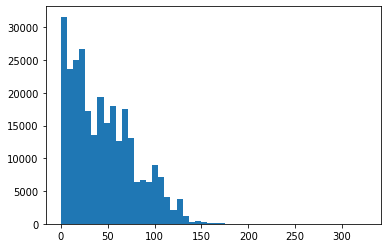

In [58]:
# приведение поля к типу integer
data['Year built'] = data['Year built'].astype('int')
data['Remodeled year'] = data['Remodeled year'].astype('int')
# Выполняем перекодировку полей в формат "Количество лет" с учетом максимального года = 2025
max_date = 2025
data['Year built'] = data['Year built'].apply(lambda x: max_date-x)
data['Remodeled year'] = data['Remodeled year'].apply(lambda x: max_date-x if x > 0 else x)
# проверяем распределение
plt.hist(data['Year built'], bins=50);

Распределение имеет экспоненциальный характер. Требуется логарифмирование признаков

In [59]:
data['year_built_log'] = np.log(data['Year built']+1)
data['remodeled_year_log'] = np.log(data['Remodeled year']+1)

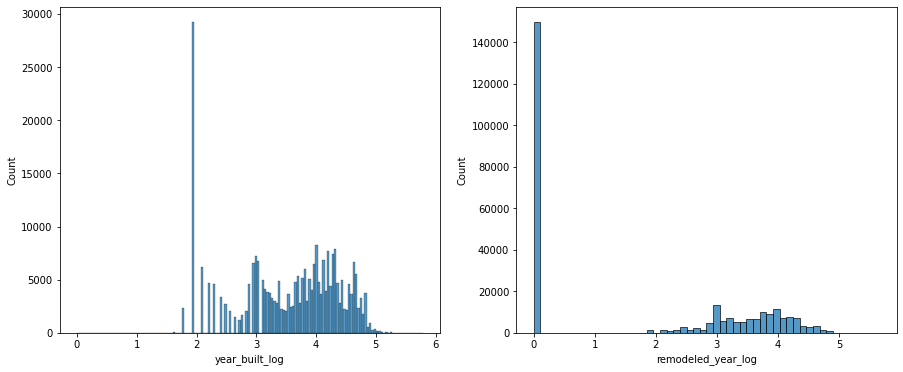

In [60]:
#постройте визуализации, иллюстрирующие результаты
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
hist1 = sns.histplot(data=data['year_built_log'], ax = axes[0])
hist2 = sns.histplot(data=data['remodeled_year_log'], ax = axes[1])

### Кодировка полей Heating, Cooling

In [61]:
# заполняем пропуски в новых признаках заглушками и приводим к упорядоченной структуре
data['Heating'] = data['Heating'].fillna('no_data')
data['Cooling'] = data['Cooling'].fillna('no_data')
data['Parking'] = data['Parking'].fillna('')
data['lotsize'] = data['lotsize'].fillna('no_data')
data['Price/sqft'] = data['Price/sqft'].fillna('no_data')
# символы переводим в нижний регистр
data['Heating'] = data['Heating'].apply(lambda x: str.lower(x))
data['Cooling'] = data['Cooling'].apply(lambda x: str.lower(x))
data['Parking'] = data['Parking'].apply(lambda x: str.lower(x))
# типизация пропусков
data['Heating'] = data['Heating'].apply(lambda x: 'no_data' if x == 'none' or x == 'other' or x == 'no data' else x)
data['Cooling'] = data['Cooling'].apply(lambda x: 'no_data' if x == 'none' or x == 'other' or x == 'no data' else x)
data['Parking'] = data['Parking'].apply(lambda x: 'no_data' if x == 'none' or x == 'other' or x == 'no data' else x)

In [62]:
# исследуем распределение признака
data['Heating'].value_counts().head(15)

Heating
forced air                     115459
no_data                         83371
central air                      7652
heat pump                        7562
electric                         6851
central electric                 6801
gas                              6497
central                          5972
central, electric                4052
baseboard                        3461
electric heat                    3056
wall                             2777
heating system                   2219
central air, ceiling fan(s)      1404
forced air, heat pump            1395
Name: count, dtype: int64

In [63]:
data['Cooling'].value_counts().head(15)

Cooling
central                                            135090
no_data                                             77148
central air                                         13411
has cooling                                          9531
central electric                                     5348
wall                                                 3535
central gas                                          3516
central heating                                      2802
cooling system                                       2211
central a/c                                          1822
central a/c (electric), central heat (gas)           1646
central a/c (electric), central heat (electric)      1429
refrigeration                                        1055
electric                                             1009
central, electric                                     964
Name: count, dtype: int64

In [64]:
# Анализ структуры данных показывает, что сведения об отоплении и кондиционировании содержатся в обоих полях.
data['Heat_Cool'] = data['Heating'] + ' // ' + data['Cooling'] # объединяем поля в одно и обрабатываем по ключевым фразам
# Heating and Cooling hand-coding
data['heating_1'] = data['Heat_Cool'].apply(lambda x: 1 if 'forced air' in x else 0).astype('int')
data['heating_2'] = data['Heat_Cool'].apply(lambda x: 1 if 'electric' in x else 0).astype('int')
data['heating_3'] = data['Heat_Cool'].apply(lambda x: 1 if 'gas' in x else 0).astype('int')
data['heating_4'] = data['Heat_Cool'].apply(lambda x: 1 if 'central' in x 
                                            or 'heating system' in x 
                                            or 'has heating' in x else 0).astype('int')
data['heating_5'] = data['Heat_Cool'].apply(lambda x: 1 if 'radiant' in x else 0).astype('int')
data['heating_6'] = data['Heat_Cool'].apply(lambda x: 1 if 'electric' in x or 'A/C' in x or 'AC' in x else 0).astype('int')
data['heating_7'] = data['Heat_Cool'].apply(lambda x: 1 if 'baseboard' in x or 'wall' in x else 0).astype('int')
data['heating_8'] = data['Heat_Cool'].apply(lambda x: 1 if 'heat pump' in x else 0).astype('int')
data['heating_9'] = data['Heat_Cool'].apply(lambda x: 1 if 'oil' in x else 0).astype('int')
data['heating_10'] = data['Heat_Cool'].apply(lambda x: 1 if 'solar' in x else 0).astype('int')
data['heating_11'] = data['Heat_Cool'].apply(lambda x: 1 if 'zoned' in x else 0).astype('int')
#
# Cooling coding
data['cooling'] = data['Heat_Cool'].apply(lambda x: 1 if 'has cooling' in x 
                                          or 'cooling system' in x 
                                          or 'refrigeration' in x 
                                          or 'evaporative' in x 
                                          or 'window unit' in x 
                                          or 'evaporative' in x 
                                          or 'condition' in x else 0).astype('int')
#
#data['ceiling_fan'] = data['Heat_Cool'].apply(lambda x: 1 if 'ceiling fan' in x else 0).astype('int')
#data['Humidity'] = data['Heat_Cool'].apply(lambda x: 1 if 'humidity' in x else 0).astype('int')
# do we need it?
#data['heating_9'] = data['Heat_Cool'].apply(lambda x: 1 if 'heating' in x else 0)
# data['heating_0'] = data['Heating'].apply(lambda x: 1 x == 'other' or x == 'no data' or x == '' or x == np.nan)
# удаляем исходное поле
data = data.drop(labels=['Heating','Cooling'], axis=1)
# удаляем исходное поле
data = data.drop(labels=['Heat_Cool'], axis=1)

### Кодировка поля Parking

In [65]:
# изучаем структуру
data['Parking'].value_counts().head(15)

Parking
no_data                             122853
attached garage                      60155
2 spaces                             22955
1 space                              12525
detached garage                      11565
carport                               6845
off street                            4566
3 spaces                              3793
1                                     2777
2                                     2473
carport, attached garage              2391
4 spaces                              2385
on street                             1511
attached garage, detached garage      1146
0                                      922
Name: count, dtype: int64

Применяем ручное кодирование

In [66]:
# Heating and Cooling hand-coding
for i in range(9):
    field_name = 'parking_'+str(i+1)
    data[field_name] = data['Parking'].apply(lambda x: 1 if str(i) in x else 0).astype('int')
    
# Parking features hand-coding
data['parking_10'] = data['Parking'].apply(lambda x: 1 if 'garage' in x else 0).astype('int')
data['parking_11'] = data['Parking'].apply(lambda x: 1 if 'attached' in x else 0).astype('int')
data['parking_12'] = data['Parking'].apply(lambda x: 1 if 'detached' in x else 0).astype('int')
data['parking_13'] = data['Parking'].apply(lambda x: 1 if 'carport' in x else 0).astype('int')
data['parking_14'] = data['Parking'].apply(lambda x: 1 if 'off street' in x or 'front' in x or 'slab' in x else 0).astype('int')
data['parking_15'] = data['Parking'].apply(lambda x: 1 if 'on street' in x or 'driveway' in x else 0).astype('int')
data['parking_16'] = data['Parking'].apply(lambda x: 1 if 'door opener' in x else 0).astype('int')
data['parking_17'] = data['Parking'].apply(lambda x: 1 if 'entry' in x else 0).astype('int')
# удаляем исходное поле
data = data.drop(labels=['Parking'], axis=1)

### Обработка и очистка поля "Lot size" (площадь земельного участка)

In [67]:
# иучаем структуру данных поля
data['lotsize']

0                no_data
1              5828 sqft
2             8,626 sqft
3             8,220 sqft
5               680 sqft
               ...      
338970        0.28 acres
338972        6,752 sqft
338973    7,084 sqft lot
338975     7,500 Sq. Ft.
338981        6,969 sqft
Name: lotsize, Length: 281781, dtype: object

In [68]:
# типизация данных
data['lotsize'] = data['lotsize'].apply(lambda x: 'no_data' if x == 'none' or x == 'No Data' else x)
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('sqft lot','sqft'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('acres lot','acre'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('Sq.Ft.','sqft'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('Sq. Ft.','sqft'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('—','no_data'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('--','no_data'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('Acre','acre'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('acres','acre'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('Acres','acre'))
# проверка наличия пропусков
data['lotsize'].isna().sum()

0

In [69]:
# вычленяем данные о единице измерения
data['lot_size'] = data['lotsize'].apply(lambda x: x.split()[0] ) # отделяем числовые данные от ед.измерения
data['mes_unit'] = data['lotsize'].apply(lambda x: x.split()[1] if len(x.split())>1 else 'no_data') # временный признак - единица измерения площади зем.участка
#
data['mes_unit'].value_counts()

mes_unit
sqft       133944
no_data     92860
acre        54977
Name: count, dtype: int64

Поле содержит данные в двух единицах измерения - кв.футы и акры. Переводим акры в кв.футы

In [70]:
# доп очистка данных
data['lot_size'] = data['lot_size'].apply(lambda x: x.replace('no_data','0'))
data['lot_size'] = data['lot_size'].apply(lambda x: x.replace(',',''))
data['lot_size'] = data['lot_size'].apply(lambda x: '0' if x == '' else x)
# приведение поля к типу float
data['lot_size'] = data['lot_size'].astype('float')
# приведение площади участка к квадратным футам
data.loc[data[data['mes_unit'] == 'acre'].index, 'lot_size'] = round(data.loc[data[data['mes_unit'] == 'acre'].index, 'lot_size'] * 43560)
# проверка на пропуски
data['lot_size'].isna().sum()

0

Обработаем выбросы

In [71]:
data[data['lot_size']<0].index

Index([], dtype='int64')

In [72]:
# функция определения выбросов методом 3х сигм
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [73]:
outliers_z, cleaned_z = outliers_z_score(data, 'lot_size', log_scale=False)
print(f'Число выбросов по методу z-отклонения: {outliers_z.shape[0]}')
print(f'Результирующее число записей: {cleaned_z.shape[0]}')

Число выбросов по методу z-отклонения: 78
Результирующее число записей: 281703


In [74]:
outliers_z['lot_size'].sort_values()

204796    2.269476e+07
66626     2.316085e+07
95786     2.352806e+07
242641    2.430648e+07
33789     2.596176e+07
              ...     
96537     7.606883e+08
231568    9.481705e+08
150301    1.045508e+09
298403    2.147480e+09
1379      2.147484e+09
Name: lot_size, Length: 78, dtype: float64

Большинство выбросов - слишком большие значения. Заполним их медианой.
Одно отрицательное значение заполним нулем

In [75]:
data.loc[outliers_z['lot_size'].index, 'lot_size'] = data['lot_size'].median()
# заполняем отрицательное значение нулем
data.loc[292924, 'lot_size'] = 0
# логарифмируем экспоненциальное распределение
data['lot_size_log'] = np.log(data['lot_size']+1)

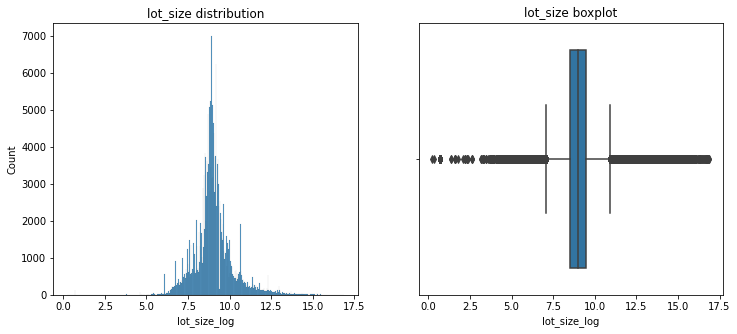

In [76]:
# проверяем распределение данных по целевой переменной
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12,5))
histplot = sns.histplot(data = data[data['lot_size_log']>0], x = 'lot_size_log', ax=axes[0])
histplot.set_title('lot_size distribution')
boxplot = sns.boxplot( data = data[data['lot_size_log']>0], x = 'lot_size_log', ax = axes[1])
boxplot.set_title('lot_size boxplot');

In [77]:
from scipy.stats import normaltest
alpha = 0.05
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

In [78]:
_, p = normaltest(data['lot_size_log'])
#normaltest возвращает двустороннюю вероятность для проверки гипотезы

print('p=%.3f' % p)

# Интерпретация 

if p > alpha/2:
	print(H0)
else:
	print(Ha)

p=0.000
Данные не распределены нормально (мы отвергаем H0)


In [79]:
# удаляем исходное поле
data = data.drop(labels=['mes_unit'], axis=1)
# удаляем исходное поле
data = data.drop(labels=['lotsize'], axis=1)

### Поле 'Price/sqft'

Сильно коррелирующее с целевой переменной поле - удалить

(теоретически из этого поля можно вытащить доп.данные для определения площади дома или наоборот - заполнения пропущенного целевого значения)

In [80]:
# удаляем исходное поле
data = data.drop(labels=['Price/sqft'], axis=1)

### Обработка поля target.

Преобразование типа целевой переменной и очистка выбросов целевой переменной

In [81]:
# удаляем строки с пустым target
data = data.dropna(axis=0, subset=['target'])

# убираем спецсимволы в поле target и помечаем для удаления строки с пометкой /mo (помесячная аренда)
specs_list = ['$',',',' ','+']

# функция обработки, удаление спецсимволов
def search_for_specs(arg):
    if '/mo' in arg: # похоже на стоимость помесячной аренды, помечаем эти записи nan для последующего удаления
        arg = np.nan
        return arg
    for symbol in arg:
        if symbol in specs_list:
            arg = arg.replace(symbol,'')
    return arg
# обрабатываем поле и преобразуем в тип float
data['target'] = data['target'].apply(search_for_specs).astype('float')

# удаляем новые строки с пустым target
data = data.dropna(axis=0, subset=['target'])
data.shape

(253818, 47)

Данные загрязнены выбросами. Необходима очистка выбросов методом 3-х сигм

In [82]:
# Удаляем строки с заведомо низкой стоимостью (<100)
data = data.drop(labels=data[data['target']<100].index, axis=0)
data.shape

(253803, 47)

In [83]:
# прологарифмируем целевую переменную
data['target_log'] = np.log(data['target']+1)
# определяем выбросы методом 3х сигм
outliers_z, cleaned_z = outliers_z_score(data, 'target_log', log_scale=False)
print(f'Число выбросов по методу z-отклонения: {outliers_z.shape[0]}')
print(f'Результирующее число записей: {cleaned_z.shape[0]}')
# продолжаем работу с очищенными данными (cleaned - метод тьюки, cleaned_z - метод 3-х сигм)
data = cleaned_z

Число выбросов по методу z-отклонения: 4185
Результирующее число записей: 249618


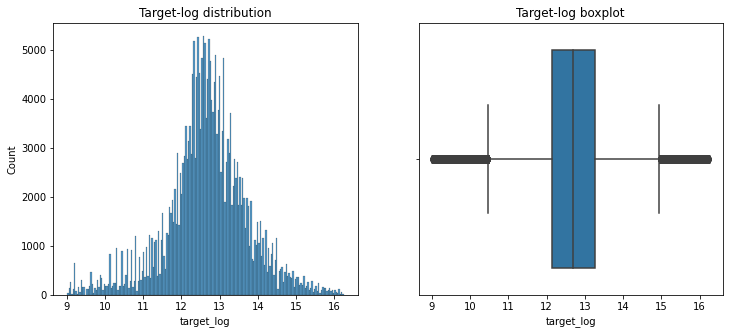

In [84]:
# проверяем распределение данных по целевой переменной
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12,5))
histplot = sns.histplot(data = data, x = 'target_log', ax=axes[0])
histplot.set_title('Target-log distribution')
boxplot = sns.boxplot( data = data, x = 'target_log', ax = axes[1])
boxplot.set_title('Target-log boxplot');

In [85]:
# проверим распределение на нормальность
_, p = normaltest(data['target_log'])
#normaltest возвращает двустороннюю вероятность для проверки гипотезы

print('p=%.3f' % p)

# Интерпретация 

if p > alpha/2:
	print(H0)
else:
	print(Ha)

p=0.000
Данные не распределены нормально (мы отвергаем H0)


### Один из основных признаков для расчета стоимости жилья - площадь. Выполним преобразование типа этого признака и очистку выбросов

In [86]:
data['sqft']

0               2900
1         1,947 sqft
2         3,000 sqft
3         6,457 sqft
5           897 sqft
             ...    
338974    3,315 sqft
338976      912 sqft
338977    2,041 sqft
338978         2,448
338979    1,360 sqft
Name: sqft, Length: 249618, dtype: object

In [87]:
# удаляем строки с пустым sqft
data = data.dropna(subset=['sqft'], axis=0)
data.shape

(222608, 48)

In [88]:
# убираем фразы и спецсимволы, заданные списком
symbols_list = ['sqft','toalinerior','total','interior','livable','area',':','--',' ',',']

def search_for_symbols(arg):
    for sub_string in symbols_list:
        if sub_string in arg:
            arg = str.lower(arg).replace(sub_string,'')
    if arg == '':
        return np.nan
    return arg
# преобразуем в тип float
data['sqft'] = data['sqft'].apply(search_for_symbols).astype('float')
# удаляем строки с пустым sqft
data = data.dropna(subset=['sqft'], axis=0)
data.shape

C:\Users\Ustenko-S\AppData\Local\Temp\ipykernel_24928\994964204.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sqft'] = data['sqft'].apply(search_for_symbols).astype('float')


(222061, 48)

In [89]:
# Удаляем строки со слишком малой площадью (<10)
data = data.drop(labels=data[data['sqft']<10].index, axis=0)
data.shape

(214738, 48)

In [90]:
outliers_z, cleaned_z = outliers_z_score(data, 'sqft', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers_z.shape[0]}')
print(f'Результирующее число записей: {cleaned_z.shape[0]}')
# продолжаем работу с очищенными данными (cleaned - метод тьюки, cleaned_z - метод 3-х сигм)
#data = cleaned
data = cleaned_z
data.shape

Число выбросов по методу z-отклонения: 1680
Результирующее число записей: 213058


(213058, 48)

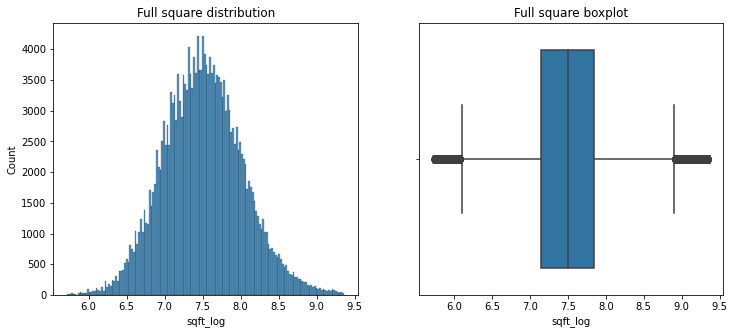

In [91]:
# логарифмируем распределение
data['sqft_log'] = np.log(data['sqft']+1)
# проверяем распределение данных по целевой переменной
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12,5))
histplot = sns.histplot(data = cleaned_z, x = 'sqft_log', ax=axes[0])
histplot.set_title('Full square distribution')
boxplot = sns.boxplot( data = cleaned_z, x = 'sqft_log', ax = axes[1])
boxplot.set_title('Full square boxplot');

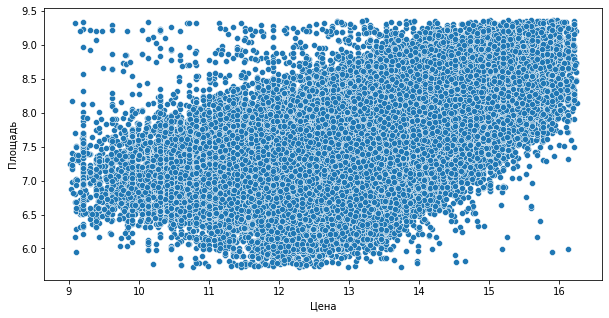

In [92]:
# оценим визуально зависимость цены недвижимости от площади 
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=data['target_log'], y=data['sqft_log'], ax=ax)
ax.set_xlabel('Цена')
ax.set_ylabel('Площадь');

Явной зависимости цены недвижимости от площади не прослеживается. Потребуется использование комплекса признаков для построения модели.

Необходимо сгенерировать больше признаков для модели

### Кодируем поле наличия бассейна

In [93]:
# изучаем структуру данных
data['PrivatePool'].value_counts()

PrivatePool
yes    18819
Yes     7075
Name: count, dtype: int64

In [94]:
# изучаем структуру данных 2-го поля
data['private pool'].value_counts()

private pool
Yes    2751
Name: count, dtype: int64

In [95]:
# определяем функцию для обработки полей
def pool_detect(arg1, arg2):
    #print(type(arg))
    if type(arg1) == str:
        if str.lower(arg1) == 'yes':
            return 1
    elif type(arg2) == str:
        if str.lower(arg2) == 'yes':
            return 1
    else:
        return 0

# кодируем поле по признаку наличия бассейна
data['pool'] = data[['private pool','PrivatePool']].apply(lambda x: pool_detect(*x), axis=1).astype('int')
data['pool'].value_counts()

pool
0    184413
1     28645
Name: count, dtype: int64

In [96]:
# удалим исходные поля
data = data.drop(labels=['private pool','PrivatePool'], axis=1)

### Кодируем "статус"

In [97]:
# изучаем значения поля статус и определяем основные признаки для кодирования
data['status'].value_counts().head(25)

status
for sale                             90794
Active                               53430
For sale                             26968
New construction                      3556
foreclosure                           3146
Pending                               3015
Pre-foreclosure                       1178
P                                     1084
Under Contract Show                    750
Pre-foreclosure / auction              719
 / auction                             576
Active Under Contract                  493
Under Contract                         478
Under Contract   Showing               470
New                                    356
Price Change                           347
Contingent                             327
A Active                               284
Auction                                259
Foreclosure                            199
Under Contract Backups                 195
Foreclosed                             185
Contingent Finance And Inspection      169
Pend

Признаки пересекаются, необходимо применить ручное кодирование

In [98]:
data['status'].isna().sum()

23035

In [99]:
# заполняем пропуски заглушкой
data['status'] = data['status'].fillna('no_data')
# переводим текстовое поле в нижний регистр
data['status'] = data['status'].apply(lambda x: str.lower(x))

# унифицируем ключевые фразы
data['status'] = data['status'].apply(lambda x: 'rental' if 'for rent' in x else x)
data['status'] = data['status'].apply(lambda x: 'active' if x == 'a active' or 'coming soon' in x else x)
data['status'] = data['status'].apply(lambda x: 'reactivated' if x == 're activated' or x == 'back on market' else x)
# проверить ????
data['status'] = data['status'].apply(lambda x: 'active backup' if x == 'backup contract' or x == 'backup' or x == 'active backup' else x)
#
data['status'] = data['status'].apply(lambda x: 'active contingent' if 'active' in x and 'contingen' in x else x)
data['status'] = data['status'].apply(lambda x: 'active option' if 'active option contract' in x else x)
#
#data['status'] = data['status'].apply(lambda x: 'pending taking backups' if x == 'pending - taking backups' else x)
data['status'] = data['status'].apply(lambda x: 'contract pending' if x == 'contract p' else x)
data['status'] = data['status'].apply(lambda x: 'pending backup' if 'pending' in x and 'backup' in x else x)
data['status'] = data['status'].apply(lambda x: 'pending contingency' if 'pending' in x and 'cont' in x else x)
data['status'] = data['status'].apply(lambda x: 'pending inspection' if x == 'p' 
                                      or x == 'pi' 
                                      or x == 'pending' 
                                      or x == 'pending in' 
                                      or x == 'pending inspection'
                                      else x)
data['status'] = data['status'].apply(lambda x: 'pending continue_to_show' if x == 'ct'
                                      or ('pending' in x and 'continue' in x and 'show' in x)
                                      else x)
data['status'] = data['status'].apply(lambda x: 'pending' if x == 'pending sale'
                                      or x == 'p pending sale'
                                      or x == 'pending sh'
                                      or x == 'ps'
                                      or x == 'pf'
                                      or ('pending' in x and 'not' in x and 'show' in x)
                                      else x)

data['status'] = data['status'].apply(lambda x: 'pre-foreclosure' if x == 'pre-foreclosure / auction' else x)
data['status'] = data['status'].apply(lambda x: 'under contract' 
                                      if x == 'under contract   showing' 
                                      or x == 'under contract show' 
                                      or x == 'active under contract' 
                                      or x == 'under contract - show' 
                                      or x == 'u under contract' 
                                      else x)
data['status'] = data['status'].apply(lambda x: 'contingency' if x == 'contingent show' 
                                      or x == 'c' 
                                      or x == 'contingency 48 hr (+/ )'
                                      or x == 'contingent   release'
                                      else x)
data['status'] = data['status'].apply(lambda x: 'foreclosured' if x == 'foreclose' else x)
data['status'] = data['status'].apply(lambda x: 'auction' if x == ' / auction' 
                                      or x == 'auction - active' 
                                      or x == 'active - auction' 
                                      else x)
data['status'] = data['status'].apply(lambda x: 'new_construction' if x == 'new' or x == 'new construction' else x)
# 
data['status'] = data['status'].apply(lambda x: x.replace('bckp','backup').replace('back up','backup').replace('backups','backup'))
data['status'] = data['status'].apply(lambda x: x.replace('accepted','accept').replace('accpt','accept').replace('accepting','accept'))
data['status'] = data['status'].apply(lambda x: x.replace('contingent','contingency').replace('accpt','accept'))
data['status'] = data['status'].apply(lambda x: x.replace('offers','offer').replace('financing','finance'))
data['status'] = data['status'].apply(lambda x: x.replace('  ',' ').replace(' - ',' ').replace('with',''))
# Удаляем строки со статусом аренда
data = data.drop(labels=data[data['status']=='rental'].index, axis=0)
data.shape

(213058, 48)

In [100]:
# собираем словарь из ключевых фраз и закодируем поле статус по словарю для достаточно часто повторяющихся слов (>100 раз)
status_codes_dict = {}

def status_processing(arg):
    dict = arg.split(' ')
    for i in range(len(dict)):
        word = dict[i]
        if word in status_codes_dict:
            status_codes_dict[word] += 1
        elif len(dict[i])>3:
            status_codes_dict[word] = 1
    
            
data['status'].apply(status_processing);
# фильтруем словарь
status_codes_dict = dict(filter(lambda item: item[1] > 100, status_codes_dict.items()))
# сводим в список частых ключевых слов
status_codes_list = list(status_codes_dict.keys())
# создание новых бинарных признаков, проходим циклом по списку ключевых фраз
for i in range(len(status_codes_list)):
    field_name = 'status_'+str(i+1)
    data[field_name] = data['status'].apply(lambda x: 1 if status_codes_list[i] in x else 0).astype('int')

data.shape

(213058, 66)

===============================================

In [101]:
# удаляем исходное поле
data = data.drop(labels=['status'], axis=1)

### Для этажности есть отдельный признак. Кодируем количество этажей с учетом данных из поля PropertyType

In [102]:
data['stories'].value_counts().head(25)

stories
1.0              42810
2.0              35113
1                15410
2                11981
3.0               7160
0.0               4699
One               4204
3                 2714
0                 2552
9.0               2076
Two               1806
2.00              1604
4.0               1390
2 Story           1304
1 Story            864
1.00               735
4                  605
3+                 537
Three Or More      412
6.0                408
5.0                382
1.50               345
9                  330
3.00               303
One Story          251
Name: count, dtype: int64

In [103]:
# заполняем пропуски заглушкой
data['stories'] = data['stories'].fillna('no_data')
# символы переводим в нижний регистр
data['stories'] = data['stories'].apply(lambda x: str.lower(x))
# унифицируем данные
data['stories'] = data['stories'].apply(lambda x: '1st' if x=='one' or x=='one story' else x)
data['stories'] = data['stories'].apply(lambda x: '2st' if x=='two' else x)
data['stories'] = data['stories'].apply(lambda x: '3st' if x=='three' else x)
data['stories'] = data['stories'].apply(lambda x: '4st' if x=='quad' else x)
data['stories'] = data['stories'].apply(lambda x: '3+st' if x=='three or more' or x=='3+' or '3+ stories' in x else x)


data['stories'] = data['stories'].apply(lambda x: '1st' if x=='1' or x[:3]=='1.0' or x=='1 story' or x=='one story' or x=='1 level' or x=='one level' or x=='one-level' else x)
data['stories'] = data['stories'].apply(lambda x: '1.5st' if x=='1.5' or x[:3]=='1.5' else x)
data['stories'] = data['stories'].apply(lambda x: '2st' if x=='2' or x[:3]=='2.0' or x=='2 story' or x=='2 stories' or x=='two story' or x=='2 level' or x=='bi-level' or x=='townhouse' else x)
data['stories'] = data['stories'].apply(lambda x: '3st' if x=='3' or x[:3]=='3.0' or x=='3 story' or x=='3 stories' or x=='three story' or x=='3 level' or x=='tri-level' or x=='t3' else x)
data['stories'] = data['stories'].apply(lambda x: '4st' if x=='4' or x[:3]=='4.0' or x=='4 story' or x=='4 stories' or x=='4 level' or x=='quad level' else x)
data['stories'] = data['stories'].apply(lambda x: '5st' if x=='5' or x[:3]=='5.0' or x=='5 story' or x=='5 level' else x)
data['stories'] = data['stories'].apply(lambda x: '6st' if x=='6' or x[:3]=='6.0' or x=='6 story' or x=='6 level' else x)
data['stories'] = data['stories'].apply(lambda x: '7st' if x=='7' or x[:3]=='7.0' or x=='7 story' or x=='7 level' else x)
data['stories'] = data['stories'].apply(lambda x: '8st' if x=='8' or x[:3]=='8.0' or x=='8 story' or x=='8 level' else x)
data['stories'] = data['stories'].apply(lambda x: '9st' if x=='9' or x[:3]=='9.0' or x=='9 story' or x=='9 level' else x)
#
data['stories'] = data['stories'].apply(lambda x: '1st/'+x if 'one' in x or '1 story' in x or '1 level' in x or 'one level' in x else x)
data['stories'] = data['stories'].apply(lambda x: '2st/'+x if 'two' in x or '2 stories' in x or '2 story' in x or '2 level' in x else x)
data['stories'] = data['stories'].apply(lambda x: '3st/'+x if 'three' in x or '3 stories' in x or '3 level' in x else x)
data['stories'] = data['stories'].apply(lambda x: '4st/'+x if 'quad' in x or '4 stories' in x or '4 level' in x else x)
#
data['stories'] = data['stories'].apply(lambda x: '' if x=='0' or x=='0.0' else x)
data['stories'] = data['stories'].apply(lambda x: '' if x=='no_data' else x)
#
data['stories'].value_counts().head(25)

stories
                           74501
1st                        64583
2st                        52491
3st                        10381
9st                         2406
4st                         2044
3+st                         951
1.5st                        766
6st                          577
5st                          520
7st                          266
8st                          248
1st/ranch/1 story            200
multi/split                  188
2st/two story or more        161
2st/2 level, site built      141
condominium                  128
1st/1 level, site built      116
2st/2 story/basement          99
ranch                         95
stories/levels                89
traditional                   65
12.0                          61
16.0                          56
mid-rise                      56
Name: count, dtype: int64

In [104]:
# создаем новые признаки для основных типов этажности
data['1_story'] = data['stories'].apply(lambda x: 1 if '1st' in x or x == '' else 0).astype('int')
data['1h_story'] = data['stories'].apply(lambda x: 1 if x=='1.5' or x[:3]=='1.5' else 0)
data['2_story'] = data['stories'].apply(lambda x: 1 if '2st' in x else 0).astype('int')
data['3_story'] = data['stories'].apply(lambda x: 1 if '3st' in x else 0).astype('int')
data['3m_story'] = data['stories'].apply(lambda x: 1 if '3+st' in x else 0).astype('int')
data['4_story'] = data['stories'].apply(lambda x: 1 if '4st' in x else 0).astype('int')
data['5_story'] = data['stories'].apply(lambda x: 1 if '5st' in x else 0).astype('int')
data['6_story'] = data['stories'].apply(lambda x: 1 if '6st' in x else 0).astype('int')
data['7_story'] = data['stories'].apply(lambda x: 1 if '7st' in x else 0).astype('int')
data['8_story'] = data['stories'].apply(lambda x: 1 if '8st' in x else 0).astype('int')

Идеи для дальнейшей обработки: можно еще слить поля stories и propertyType так как в них много общих данных

In [105]:
# удаляем исходное поле
data = data.drop(labels=['stories'], axis=1)

### Кодируем тип недвижимости "propertyType"

In [106]:
# исследуем структуру данных поля
data['propertyType'].value_counts().head(10)

propertyType
single-family home               58199
Single Family                    37594
Single Family Home               18931
condo                            18276
Condo                            11735
townhouse                         7656
Condo/Townhome/Row Home/Co-Op     5231
multi-family                      4862
Traditional                       4367
Townhouse                         4356
Name: count, dtype: int64

Здесь также лучше подойдет ручное кодирование

In [107]:
# заполняем пропуски заглушкой
data['propertyType'] = data['propertyType'].fillna('unknown')
# символы переводим в нижний регистр
data['propertyType'] = data['propertyType'].apply(lambda x: str.lower(x))
data['propertyType'] = data['propertyType'].apply(lambda x: 'unknown' if x == ' ' else x)
# унификация данных
#data['propertyType'] = data['propertyType'].apply(lambda x: 'no_data' if x == 'none' or x == 'No Data' else x)
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('one story','1st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('1 story','1st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('2 stories','2st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('two story','2st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('bilevel','2st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('2 levels','2st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('tri-level','3st'))
data['propertyType'] = data['propertyType'].apply(lambda x: '3st' if x == 'tri-level' else x)
data['propertyType'] = data['propertyType'].apply(lambda x: '3st' if x == 'less than 4 floors' else x)
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('2 story','2st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('bi-level ','split'))
#data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('split-level','2st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('midcentury','mid century').replace('midcentury','mid-century'))
data['propertyType'] = data['propertyType'].apply(lambda x: 'unknown' if 'other' in x or x == 'miscellaneous' or x == 'custom' or x == '' or x == ' ' else x)

In [108]:
extra_data_status = pd.DataFrame()
# собираем ключевые фразы для кодирования статусов
status_codes = [['single','family','detached','tiny home'],
                '1st','2st','3st',
                'condo','town','tradition','craftsman','cottage','high','federal','tudor','loft','split-entry',
                'split','basement','penthouse','historic','fourplex','mid-rise','duplex','french','elevated','a-frame',
                'bungalow','coastal',
                ['flat','apartment'],
                ['mid-rise','3+ stories'],
                ['beaux arts','art deco'],
                ['mediterran','spanish'],
                ['colonial','georgian','charleston'],
                ['english','victorian'],
                ['santa barbara','tuscan'],
                ['multi','cluster'],
                ['florida','cape','key west'],
                ['contemp','modern'],
                ['ranch','farm'],
                ['coop','co-op'],
                ['mobile','carriage'],
                ['manufactur','prefab','modular']]
# создание новых бинарных признаков проходим циклом по списку ключевых фраз
for i in range(len(status_codes)):
    if type(status_codes[i])==list and len(status_codes[i]) == 2:
        field_name = 'type_'+str(i+1)
        extra_data_status[field_name] = data['propertyType'].apply(lambda x: 1 if status_codes[i][0] in x or status_codes[i][1] in x else 0).astype('int')
    elif type(status_codes[i])==list and len(status_codes[i]) == 3:
        field_name = 'type_'+str(i+1)
        extra_data_status[field_name] = data['propertyType'].apply(lambda x: 1 if status_codes[i][0] in x or status_codes[i][1] in x or status_codes[i][2] in x else 0).astype('int')
    elif type(status_codes[i])==list and len(status_codes[i]) == 4:
        field_name = 'type_'+str(i+1)
        extra_data_status[field_name] = data['propertyType'].apply(lambda x: 1 if status_codes[i][0] in x 
                                                      or status_codes[i][1] in x 
                                                      or status_codes[i][2] in x 
                                                      or status_codes[i][3] in x else 0).astype('int')
    else:
        field_name = 'type_'+str(i+1)
        extra_data_status[field_name] = data['propertyType'].apply(lambda x: 1 if status_codes[i] in x else 0).astype('int')
# считаем количество новых признаков
len(status_codes)

40

In [109]:
# тип земля или съемная квартира - помечаем на удаление
extra_data_status['type_lot'] = data['propertyType'].apply(lambda x: 1 if 'lot' in x or 'land' in x else 0).astype('int')
# склеиваем датафреймы
data = pd.concat([data, extra_data_status], axis=1)
# удаляем исходное поле
data = data.drop(labels=['propertyType'], axis=1)
# Удаляем строки с типом "земельный участок"
data = data.drop(labels=data[data['type_lot']==1].index, axis=0)
data.shape

(210691, 114)

In [110]:
# удаляем исходное поле "земельный участок"
data = data.drop(labels=['type_lot'], axis=1)

### Кодируем количество спален

In [111]:
data['beds']

0              4
1         3 Beds
2         3 Beds
3         5 Beds
5         2 Beds
           ...  
338974      4 bd
338976    2 Beds
338977    3 Beds
338978         4
338979    3 Beds
Name: beds, Length: 210691, dtype: object

In [112]:
data['beds'].isna().sum()

33832

In [113]:
# заполняем пропуски заглушкой - нулем.
data['beds'] = data['beds'].fillna('0')
# убираем спецсимволы в поле target и помечаем для удаления строки с пометкой /mo (помесячная аренда)
words_list = ['beds',' ','bd','--']

def search_for_symbols(arg):
    for sub_string in words_list:
        if sub_string in str.lower(arg):
            arg = str.lower(arg).replace(sub_string,'')
    if 'sqft' in str.lower(arg) or 'bath' in str.lower(arg) or 'price' in str.lower(arg):
        return 1
    if arg == '':
        return 1
    return arg

# удаляем символы и преобразуем в тип float
data['beds'] = data['beds'].apply(search_for_symbols).astype('float').astype('int')

### Кодируем количество ванных комнат

In [114]:
data['baths']

0             3.5
1         3 Baths
2         2 Baths
3         8 Baths
5             NaN
           ...   
338974       4 ba
338976    2 Baths
338977    4 Baths
338978          2
338979    2 Baths
Name: baths, Length: 210691, dtype: object

In [115]:
# заполняем пропуски заглушкой
data['baths'] = data['baths'].fillna('0')
# убираем спецсимволы в поле target и помечаем для удаления строки с пометкой /mo (помесячная аренда)
words_list = ['baths',' ','bathrooms:','ba','~','+','/','sq.ft.','-','semimod','—']

def search_for_symbols(arg):
    for sub_string in words_list:
        if sub_string in str.lower(arg):
            arg = str.lower(arg).replace(sub_string,'')
    if ',' in str.lower(arg):
        arg = str.lower(arg).replace(',','.')
    if arg == '':
        return 1
    return arg

# удаляем символы и преобразуем в тип целый
data['baths'] = data['baths'].apply(search_for_symbols).astype('float').astype('int')

Поле "кол-во ванных комнат" содержит странные числа. Все что больше 10 приравниваем 1

In [116]:
# заменяем странные значения на 1
data['baths'] = data['baths'].apply(lambda x: 1 if x > 20 else x)
data['baths'].value_counts()

baths
2     77605
3     46714
0     40568
1     17441
4     17361
5      6028
6      2659
7      1172
8       588
9       229
10      117
11       72
12       53
13       23
16       19
14       16
18       10
15        8
20        5
17        2
19        1
Name: count, dtype: int64

### Кодируем количество каминов

In [117]:
data['fireplace'].value_counts().head(10)

fireplace
yes               31298
Yes               12622
1                 10058
2                  1624
Not Applicable     1201
Fireplace           587
3                   362
Living Room         258
LOCATION            232
Wood Burning        225
Name: count, dtype: int64

In [118]:
# заполняем пропуски заглушкой
data['fireplace'] = data['fireplace'].fillna('0')
# символы переводим в нижний регистр
data['fireplace'] = data['fireplace'].apply(lambda x: str.lower(x))

In [119]:
extra_data = pd.DataFrame()
# собираем ключевые фразы для кодирования статусов
fireplace_keys = ['gas','closet','electric','storage','extra','utility connection',
                  ['logs','wood'],
                  ['brick','masonry']]
# создание новых бинарных признаков
for i in range(len(fireplace_keys)):
    if type(fireplace_keys[i])==list and len(fireplace_keys[i]) == 2:
        field_name = 'fp_'+str(i+1)
        extra_data[field_name] = data['fireplace'].apply(lambda x: 1 if fireplace_keys[i][0] in x or fireplace_keys[i][1] in x else 0).astype('int')
    else:
        field_name = 'fp_'+str(i+1)
        extra_data[field_name] = data['fireplace'].apply(lambda x: 1 if fireplace_keys[i] in x else 0).astype('int')

In [120]:
# кодируем поле по количеству каминов
fireplace_yes_words = ['gas','wood','family','features','room','den','firepit']
#fireplace_no_words = ['decorative', 'n/k', 'not app', 'fireplace yn', 'electric', 'no fireplace']

def search_for_words(arg):
    if arg == 'yes' or arg == 'fireplace' or '1' in arg or 'one' in arg:
        return 1
    elif 'two' in arg or '2' in arg:
        return 2
    elif '3' in arg:
        return 3
    else:
        for word in fireplace_yes_words:
            if word in arg:
                return 1
        return 0

# 
data['fireplace'] = data['fireplace'].apply(search_for_words).astype('int')
# склеиваем датафреймы
data = pd.concat([data, extra_data], axis=1)
data.shape

(210691, 121)

### Распаковываем поле Scools

In [121]:
# перестраиваем индекс и далее работаем с копией датасета с новым индексом
data_reset = data.reset_index()

In [122]:
# распаковка поля schools и извлечение новых признаков
schools_list_1 = list() # создаем пустой список для словарей
schools_list_2 = list() # создаем пустой список для словарей
# создаем новый датафрейм для обработки школьных данных
extra_data = pd.DataFrame(data_reset['schools'])

def schools_unpack(arg): # функция распаковки поля schools
    schools_list_1.append(eval(arg)[0])
    schools_list_2.append(eval(arg)[0]['data'])
    
# обрабатываем поле функцией
data_reset['schools'].apply(schools_unpack);
# преобразуем списки словарей в датафреймы
extra_data_1 = pd.DataFrame(schools_list_1)
extra_data_2 = pd.DataFrame(schools_list_2)
# склеиваем датафреймы
extra_data = pd.concat([extra_data, extra_data_1], axis=1)
extra_data = pd.concat([extra_data, extra_data_2], axis=1)
# новые признаки
extra_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210691 entries, 0 to 210690
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   schools   210691 non-null  object
 1   rating    210691 non-null  object
 2   data      210691 non-null  object
 3   name      210691 non-null  object
 4   Distance  210691 non-null  object
 5   Grades    210691 non-null  object
dtypes: object(6)
memory usage: 9.6+ MB


Можно посчитать количество школ в окрестности объекта, средний рейтинг школ, среднюю дистанцию по трем новым признакам

### Обработка поля schools

In [123]:
# Определяем новый признак - количество школ в округе
extra_data['school_count'] = extra_data['name'].apply(lambda x: len(x)).astype('int')

### Определяем новые признаки из расстояний до школ

In [124]:
def school_distance_avg(arg):
    """функция рассчета среднего расстояния до школ

    Args:
        arg (list): список из чисел с обозначением mi

    Returns:
        float: средний рейтинг
    """
    n = 0
    if len(arg) > 0: # если список не пустой
        for i in arg: # цикл по списку
            i = re.sub(r'[a-zA-Z ]', '', i) # удаляем символы
            if i != '':
                n += float(i)
        return round(n / len(arg),1)
    else:
        return 0
    
def school_distance_min(arg):
    """ функция рассчета расстояния до ближайшей школы

    Args:
        arg (list): список из чисел с обозначением mi из поля Distance

    Returns:
        list: список из двух элементов: мин расстояние и номер школы
    """
    
    n = 999
    if len(arg) > 0: # если список не пустой
        counter = min_number = 0
        for i in arg: # цикл по списку
            i = re.sub(r'[a-zA-Z ]', '', i) # удаляем символы
            if i != '' and float(i) < n:
               min_number = counter
               n = float(i)
            counter += 1
        return [min_number, n]
    else:
        return [0, 999]
# добавляем новые признаки
extra_data['school_distance_min'] = extra_data['Distance'].apply(school_distance_min) # расстояние до ближайшей школы
extra_data['school_distance_avg'] = extra_data['Distance'].apply(school_distance_avg) # среднее расстояние до школ

### "Средний рейтинг школ в округе"

In [125]:
def rating_processing(arg):
    """ функция рассчета среднего рейтинга школ

    Args:
        arg (list): список из чисел из поля rating, содержащий спецсимволы

    Returns:
        list: очищенный список из чисел
    """
    if len(arg) > 0:
        for i in range(len(arg)):
            arg[i] = re.sub(r'[a-zA-Z/10]', '', arg[i])
        return arg
    else:
        return arg

extra_data['school_rating'] = extra_data['rating'].apply(rating_processing)

In [126]:
extra_data['school_rating']

0         [4, 4, 7, , 4, 7, , ]
1                      [4, , 4]
2                     [8, 4, 8]
3                   [9, 9, , 9]
4                            []
                  ...          
210686                [6, 5, 6]
210687                [6, 4, 5]
210688                [4, 4, 3]
210689                 [3, , 2]
210690                [6, 6, 4]
Name: school_rating, Length: 210691, dtype: object

In [127]:
def rating_processing(arg):
    """ функция рассчета среднего рейтинга школ

    Args:
        arg (list): список из чисел из поля rating, содержащий спецсимволы
    """
    n = 0
    if len(arg) > 0:
        for i in arg:
            if i != '':
                n += int(i)
        return round(n / len(arg),1)
    else:
        return 0

extra_data['school_rating_avg'] = extra_data['school_rating'].apply(rating_processing)
# extra_data['school_rating_avg'] = extra_data['rating'].apply(rating_processing)
#extra_data['school_rating_avg'] = extra_data['rating'].apply(rating_processing).astype('int')

### Рейтинг ближайшей школы

In [128]:
# определяем ближайшую школу
extra_data['school_nearest'] = extra_data['school_distance_min'].apply(lambda x: x[0])
def rating_nearest_school(x, y):
    if len(x)>0:
        return x[y]
    else:
        return 0

# создаем новые признаки - рейтинг и расстояние до ближайшей школы
extra_data['school_rating_prx'] = extra_data.apply(lambda row: rating_nearest_school(row['school_rating'],row['school_nearest']), axis=1)
extra_data['school_distance_min'] = extra_data['school_distance_min'].apply(lambda x: x[1])

Обработаем пропуски. Заполним средним значением пропуски в поле 'school_distance_min'

In [129]:
extra_data['school_rating_prx'].value_counts()

school_rating_prx
4    27730
     27667
5    27245
3    26210
6    24557
7    22689
2    20300
8    19203
9    13382
0     1708
Name: count, dtype: int64

In [130]:
extra_data.loc[extra_data[extra_data['school_rating_prx']==''].index, 'school_rating_prx'] = np.nan
extra_data['school_rating_prx'] = extra_data['school_rating_prx'].astype('float')
# обрабатываем странные значения Year built, пропускам присваиваем NaN
extra_data.loc[extra_data[extra_data['school_distance_min']==999].index, 'school_distance_min'] = np.nan
extra_data.loc[extra_data[extra_data['school_distance_min']==0].index, 'school_distance_min'] = np.nan
extra_data.loc[extra_data[extra_data['school_distance_avg']==0].index, 'school_distance_avg'] = np.nan
extra_data.loc[extra_data[extra_data['school_rating_avg']==0].index, 'school_rating_avg'] = np.nan
extra_data.loc[extra_data[extra_data['school_rating_prx']==''].index, 'school_rating_prx'] = np.nan
extra_data.loc[extra_data[extra_data['school_rating_prx']==0].index, 'school_rating_prx'] = np.nan
extra_data['school_distance_min'].isna().sum()

2071

In [131]:
extra_data = extra_data.fillna({
    'school_distance_min': round(extra_data['school_distance_min'].mean(),1),
    'school_distance_avg': round(extra_data['school_distance_avg'].mean(),1),
    'school_rating_avg': round(extra_data['school_rating_avg'].mean(),1),
    'school_rating_prx': round(extra_data['school_rating_prx'].mean(),1)
    } )
extra_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210691 entries, 0 to 210690
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   schools              210691 non-null  object 
 1   rating               210691 non-null  object 
 2   data                 210691 non-null  object 
 3   name                 210691 non-null  object 
 4   Distance             210691 non-null  object 
 5   Grades               210691 non-null  object 
 6   school_count         210691 non-null  int32  
 7   school_distance_min  210691 non-null  float64
 8   school_distance_avg  210691 non-null  float64
 9   school_rating        210691 non-null  object 
 10  school_rating_avg    210691 non-null  float64
 11  school_nearest       210691 non-null  int64  
 12  school_rating_prx    210691 non-null  float64
dtypes: float64(4), int32(1), int64(1), object(7)
memory usage: 20.1+ MB


In [132]:
# удаляем исходные столбцы
data_reset.drop(labels=['schools','index'], axis=1, inplace=True)
# удаляем исходный столбец
extra_data.drop(labels=['name','rating','data','Grades','Distance','schools','school_rating','school_nearest'], axis=1, inplace=True)

In [133]:
# склеиваем датафреймы
data_reset = pd.concat([data_reset, extra_data], axis=1)
data_reset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210691 entries, 0 to 210690
Columns: 125 entries, baths to school_rating_prx
dtypes: float64(44), int32(79), int64(2)
memory usage: 137.4 MB


Выгружаем подготовленный датасет в файл

In [134]:
# выгрузка данных в файл
data_reset.to_csv("./data/data_prepared.csv", sep=',', index=False)